# Exercices : courbe de luminosité d'une galaxie

In [1]:
# courbe de luminosité d'une galaxie

In [2]:
%matplotlib notebook
import numpy as np
import pylab as pl
import astropy.io.fits
import astropy.modeling
import astropy.modeling.fitting

http://archive.stsci.edu/cgi-bin/dss_form?target=ngc+7331&resolver=SIMBAD

In [3]:
# open fits file
ngc7331_hdulist = astropy.io.fits.open('files/ngc7331.fits')
ngc7331_hdu = ngc7331_hdulist[0]
ngc7331_map = ngc7331_hdu.data

In [4]:
# compute inclination angle
# http://ned.ipac.caltech.edu/cgi-bin/nph-objsearch?objname=NGC%207331&extend=no&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES#BasicData_0
major = 10.5
minor = 3.7
# http://www.sos.siena.edu/~rfinn/astron337/mod2/2mass.3/node5.html
print np.degrees(np.arcsin(np.sqrt(1 - (minor/major)**2)))

69.36698587133556


<IPython.core.display.Javascript object>


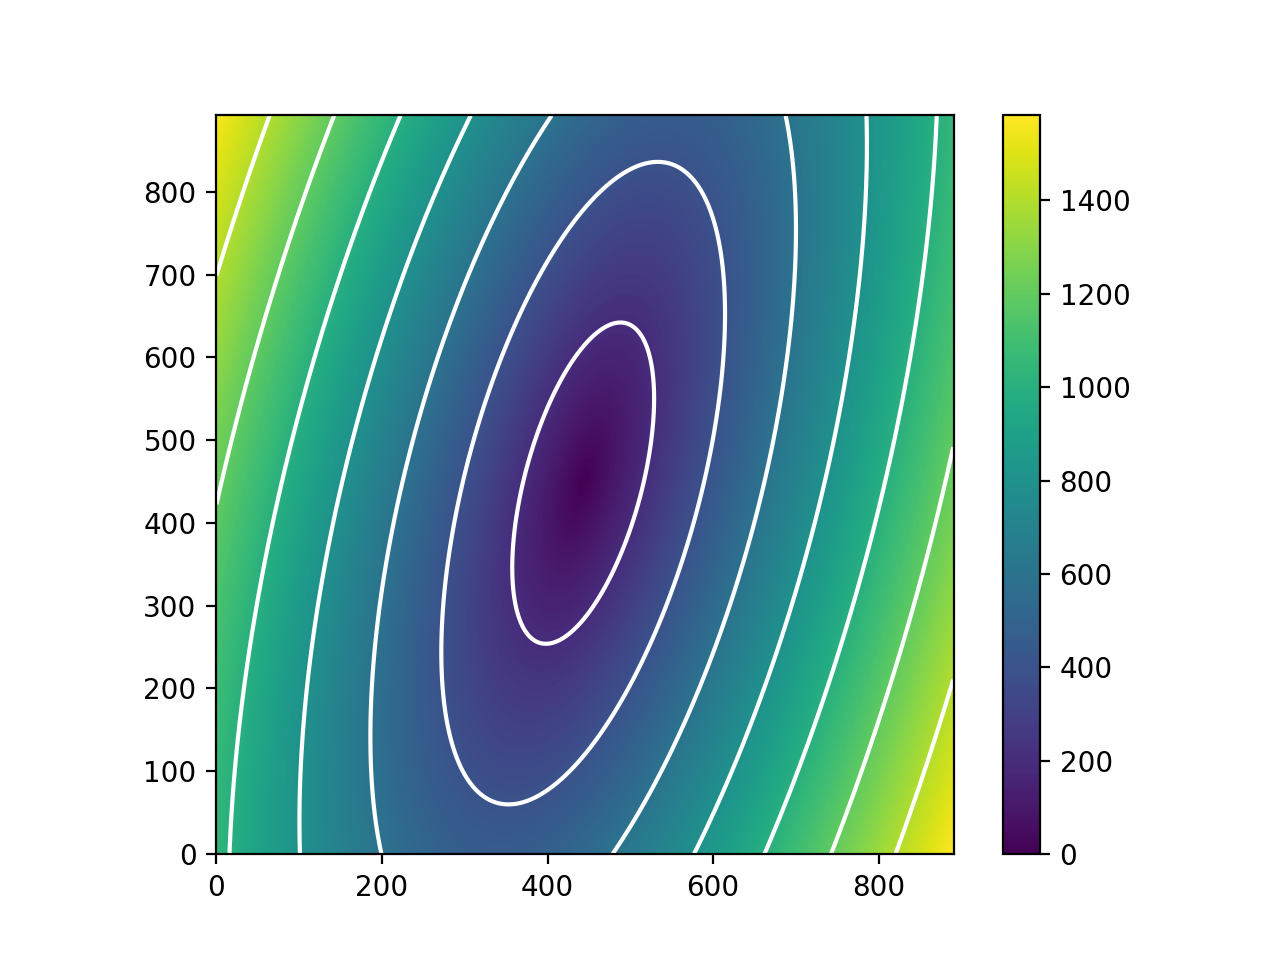

<IPython.core.display.Javascript object>


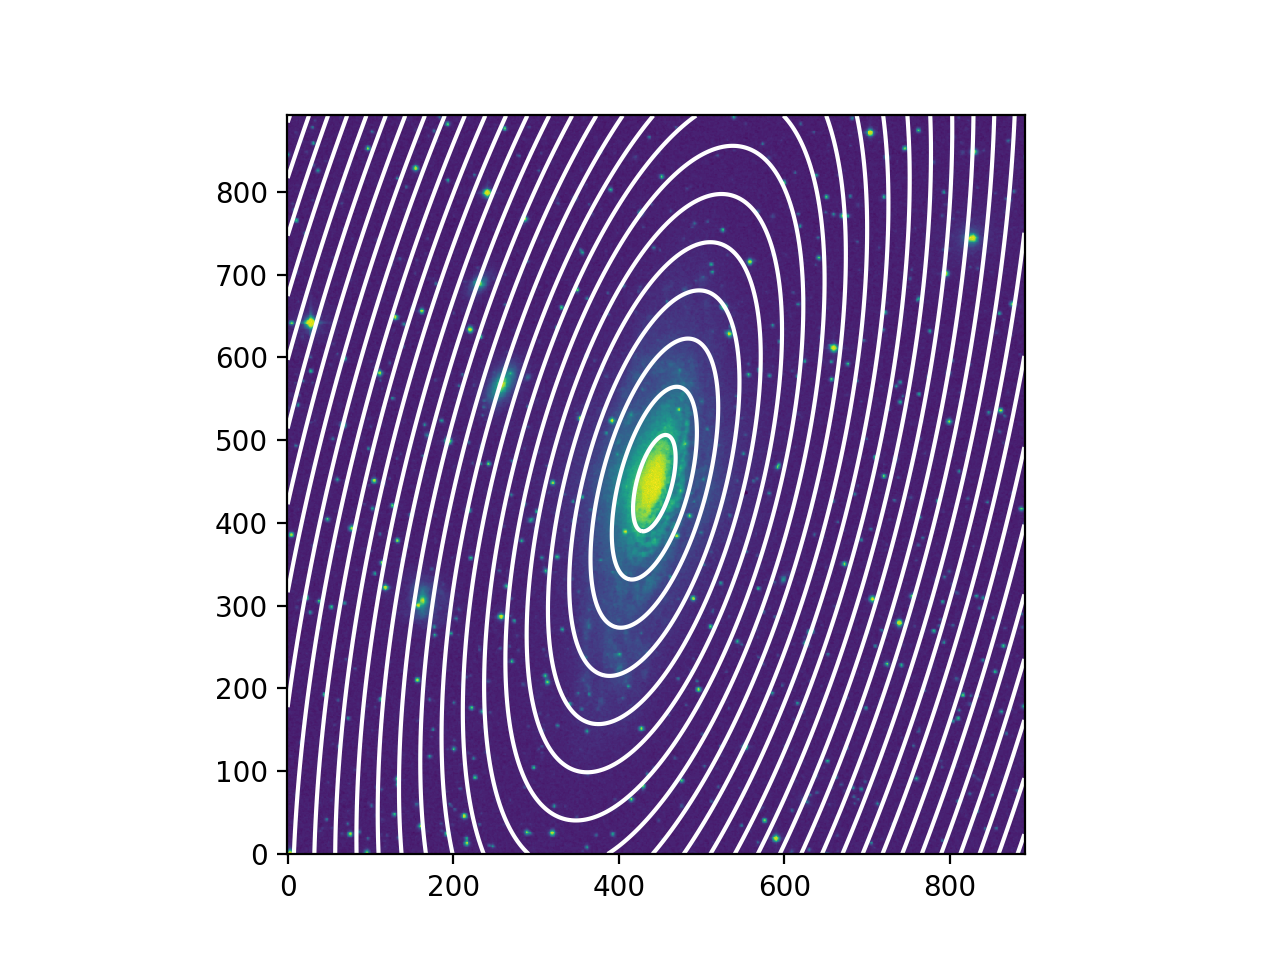

In [9]:
# compute projected radius
X, Y = np.mgrid[0:float(ngc7331_map.shape[0]),
                0:float(ngc7331_map.shape[1])]

cx = 448
cy = 443
i_angle = np.radians(69.3)
r_angle = np.radians(-15)

# centering
X -= cx
Y -= cy

# rotation of the coordinates
Xr = X * np.cos(r_angle) - Y * np.sin(r_angle)
Yr = X * np.sin(r_angle) + Y * np.cos(r_angle)

# compute radius
R = np.sqrt((Xr)**2  + (Yr / np.cos(i_angle))**2)


pl.figure()
pl.imshow(R, origin='bottom-left')
pl.colorbar()

pl.contour(R, colors='white')

pl.figure()
pl.imshow(ngc7331_map, origin='bottom-left')
pl.contour(R, 30, colors='white')

<IPython.core.display.Javascript object>


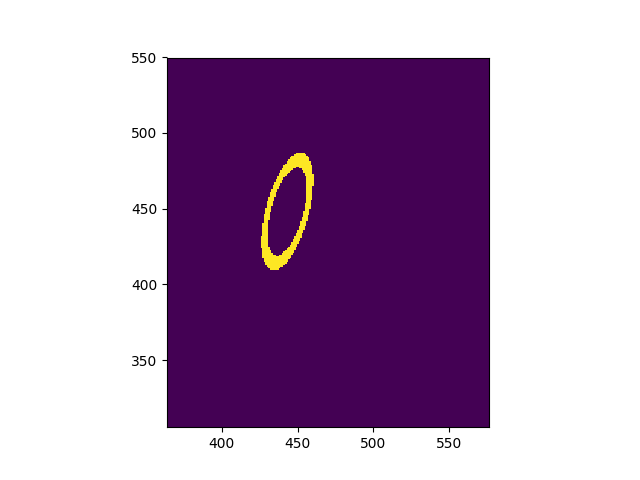

In [79]:
# compute annulus
pl.figure()
pl.imshow((30 < R) * (R < 40), origin='bottom-left')

<IPython.core.display.Javascript object>


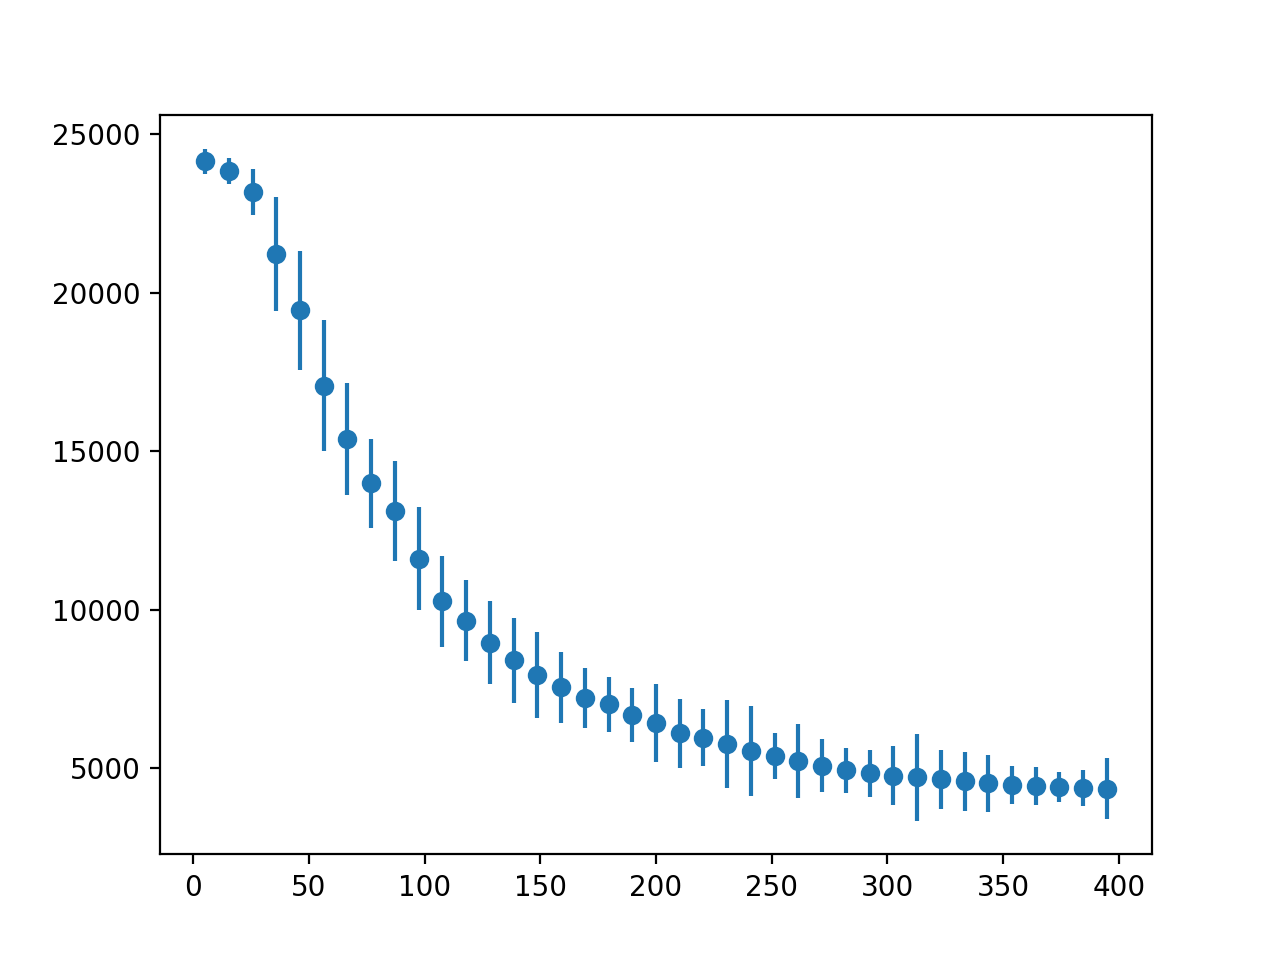

<Container object of 3 artists>

In [11]:
# compute luminosity profile
radii = np.linspace(0, 400, 40)
profile = list()
profile_err = list()
for irad in range(len(radii) - 1):
    annulus = (radii[irad] < R) * (R < radii[irad+1])
    brightness_dist = ngc7331_map[np.nonzero(annulus)]
    profile.append(np.nanmedian(brightness_dist))
    profile_err.append(np.nanstd(brightness_dist))

profile = np.array(profile)
profile_err = np.array(profile_err)
radii_axis = radii[:-1] + np.diff(radii) / 2.
pl.figure()
pl.errorbar(radii_axis, profile, yerr=profile_err, fmt='o')
    

In [10]:
# fit the luminosity profile
# http://docs.astropy.org/en/stable/modeling/index.html

g_init = astropy.modeling.functional_models.Sersic1D(
    amplitude=1000, r_eff=1000, n=2.)
fit_g = astropy.modeling.fitting.LevMarLSQFitter()
weights = 1./profile_err

g = fit_g(g_init, radii_axis, profile, weights=weights)
print g
pl.figure()
pl.errorbar(radii_axis, profile, yerr=profile_err, fmt='o')
pl.plot(radii_axis, g(radii_axis), c='orange')


NameError: name 'profile_err' is not defined

Model: Sersic1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
        amplitude            r_eff               n        
    ------------------ ----------------- -----------------
    102.11994643156461 5471.766466694756 3.728963427547315


<IPython.core.display.Javascript object>


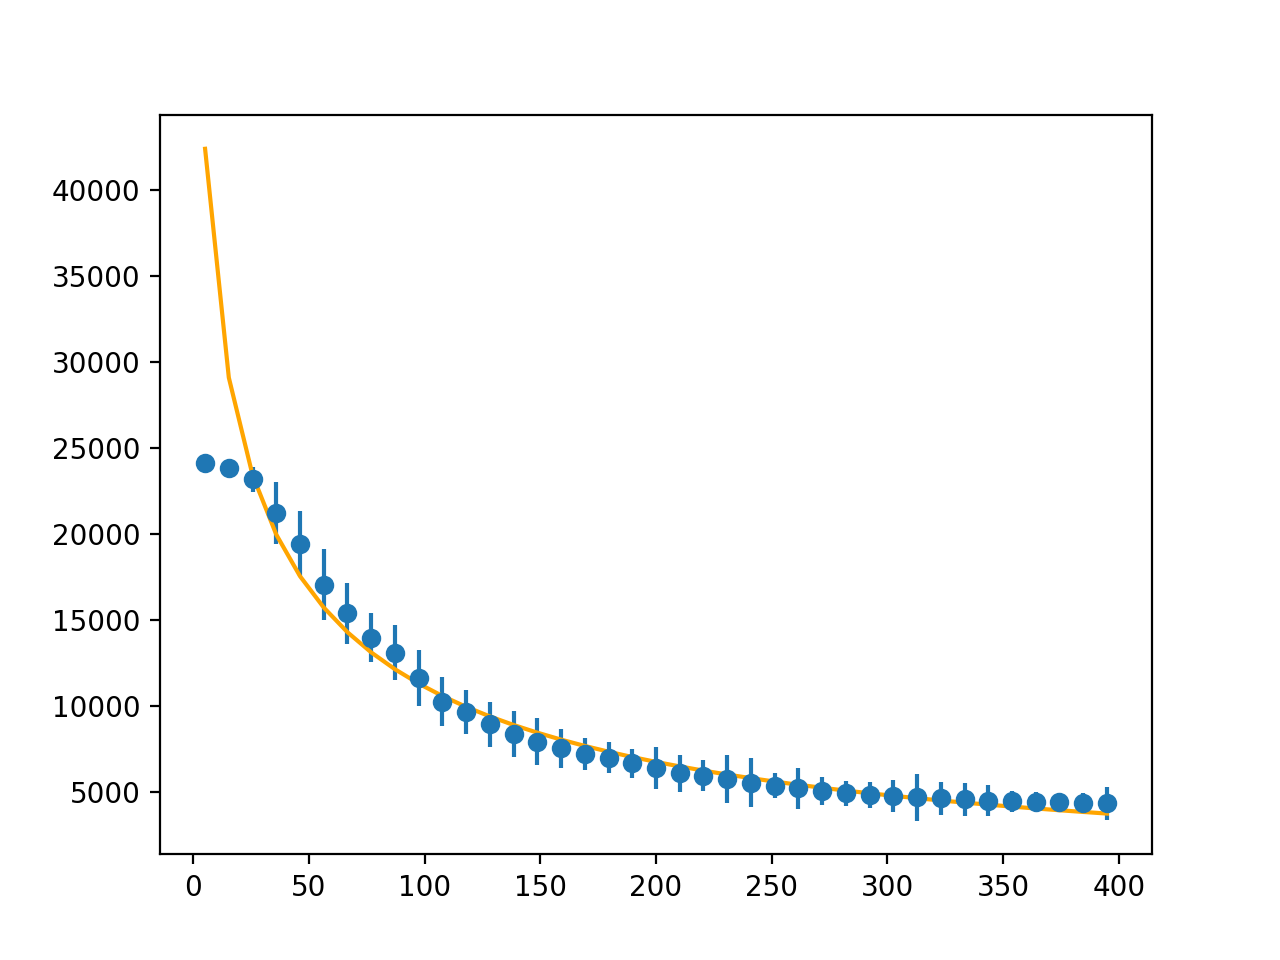

In [14]:
# fit the luminosity profile without considering the center

g_init = astropy.modeling.functional_models.Sersic1D(
    amplitude=1000, r_eff=1000, n=2.)
fit_g = astropy.modeling.fitting.LevMarLSQFitter()
weights = 1./profile_err
weights[np.nonzero(radii_axis < 50)] = 0. # removing central points

g = fit_g(g_init, radii_axis, profile, weights=weights)
print g
pl.figure()
pl.errorbar(radii_axis, profile, yerr=profile_err, fmt='o')
pl.plot(radii_axis, g(radii_axis), c='orange')